In [1]:
# PyTorch package and submodules
import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer

# NumPy for math operations, and Pandas for processing tabular data.
import numpy as np
import pandas as pd

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

# Import matplotlib.pyplot to visualize tree models
import matplotlib.pyplot as plt

# Use imbalanced learn package
from imblearn.over_sampling import SMOTE

from genetic_selection import GeneticSelectionCV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix


from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split as tts, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier as XGBC
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [2]:
# Draw matrix fig using seaborn
def matrix_fig(title,y,yp):
  cm = confusion_matrix(y, yp)
  mtfig = sns.heatmap (cm, annot=True, fmt="d",cmap="YlGnBu")
  mtfig.set_title(title)
  mtfig.set_ylabel('True 1abel')
  mtfig.set_xlabel('predicted label')

# Evaluation of models
def evaluation(title, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  False_precision_score = cm[0, 0] / (cm[0, 0] + cm[1, 0]) # 负样本查准率（精准率）
  False_recall_score = cm[0, 0] / (cm[0, 0] + cm[0, 1]) #负样本查全率（召回率）
  False_fl_score = 2/(1/ False_precision_score + 1 / False_recall_score)
  print(title+"_Ture_precision_score:", round(metrics.precision_score(y_test, y_pred), 4))
  print(title+"_Ture_recall_score :", round(metrics.recall_score(y_test, y_pred) , 4))
  print(title+"_Ture_F1_score:", round(f1_score(y_test, y_pred) , 4))
  print(title+"_False_precision_score:", round(False_precision_score, 4))
  print(title+"_False_recall_score :", round(False_recall_score, 4))
  print(title+"_False_F1_score:", round(False_fl_score, 4))
  print(title+"accuracy_score",round(metrics.accuracy_score(y_test, y_pred) , 4))
  x = [u"Ture_precision_score",u"Ture_recall_score", u"Ture_F1_score",u"False_precision_score",u"False_recall_score",u"False_F1_score",u"accuracy_score"]
  y = [round(metrics.precision_score(y_test, y_pred), 4),
       round(metrics.recall_score(y_test, y_pred) , 4),
       round(f1_score(y_test, y_pred) , 4),
       round(False_precision_score, 4),
       round(False_recall_score, 4),
       round(False_fl_score, 4),
       round(metrics.accuracy_score(y_test, y_pred) , 4)]
  fig, ax = plt.subplots()
  ax.bar(x, y)
  ax.set_xticklabels(x, rotation=90)
  ax.set_xlabel('Param')
  ax.set_ylabel('Score')
  ax.set_title(title)
  for a,b in zip(x,y):
    plt.text(a,b +0.01, '%.3f' %b, ha='center', va = 'bottom', fontsize = 7)
  plt.show()

# Roc_Auc 
def roc_auc_fig(title, y_test, y_pred) :
  fpr,tpr,threshold = roc_curve(y_test, y_pred) #计算真正率和假正率
  roc_auc = auc(fpr,tpr)  ##计算auc的值
  plt.figure()
  lw = 2
  plt.figure(figsize=(5,4))
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area =%0.2f)' %roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0,1.05])
  plt.xlabel ( 'False Positive Rate' )
  plt.ylabel ( 'True Positive Rate' )
  plt.title (title+ 'Receiver operating characteristic example' )
  plt.legend (loc="lower right" )
  plt.show( )

# Import Data

In [4]:
df2 = pd.read_csv("/Users/Siqi/Desktop/SPH6004/Assignment_1_data.csv")
feature_columns = df2.columns[~df2.columns.isin(['outcome'])]
target_column = 'outcome'
df2["outcome"] = df2["outcome"].astype(int)
df2['gender'] = df2['gender'].replace({'F':0,'M':1})

for i in feature_columns:
  df2[i] = pd.to_numeric(df[i])

#df.replace({'outcome': {'False': 0, 'True': 1}})
#df['gender'].replace(to_replace = 'M', value = 1, inplace = True)

df2.head()
#df.info()
#df.shape

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_indirect_min,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,1,54.550390,93.0,115.0,103.500000,57.0,100.0,82.733333,87.0,163.0,...,NaN,3459.0,2.0,0.0,NaN,1.0,0.0,1.0,3,0
1,1,86.324653,50.0,61.0,54.333333,61.0,93.0,71.695652,95.0,141.0,...,NaN,2020.0,NaN,1.0,NaN,1.0,1.0,1.0,8,0
2,1,40.270146,70.0,105.0,83.434783,66.0,92.0,76.695652,94.0,129.0,...,NaN,3050.0,NaN,1.0,0.0,1.0,1.0,0.0,4,0
3,1,73.383547,68.0,98.0,83.880000,74.0,101.0,84.694444,83.0,148.0,...,NaN,1592.0,NaN,0.0,NaN,0.0,0.0,1.0,6,0
4,1,70.724748,77.0,95.0,85.771429,30.0,90.0,62.657143,52.0,129.0,...,NaN,339.0,2.0,0.0,0.0,4.0,1.0,3.0,10,0


In [5]:
df = df2.sample(frac =.15)

# Data pre-processing (missing data)

In [6]:
# Check the percentage of missing values
missing_perc = df.isnull().sum() / len(df)
missing_perc

gender                        0.000000
age                           0.000000
heart_rate_min                0.002741
heart_rate_max                0.002741
heart_rate_mean               0.002741
mbp_min                       0.003106
mbp_max                       0.003106
mbp_mean                      0.003106
sbp_min                       0.004385
sbp_max                       0.004385
sbp_mean                      0.004385
dbp_min                       0.004385
dbp_max                       0.004385
dbp_mean                      0.004385
temperature_min               0.010780
temperature_max               0.010780
temperature_mean              0.010780
lactate_min                   0.563494
lactate_max                   0.563494
ph_min                        0.486205
ph_max                        0.486205
chloride_min                  0.831719
chloride_max                  0.831719
calcium_min                   0.746026
calcium_max                   0.746026
sodium_min               

In [7]:
# Drop columns with missing values percentage geater than 0.5
missing_drop = missing_perc[missing_perc > 0.5].index.tolist()
print(missing_drop)
df.drop(missing_drop, axis=1, inplace=True)

['lactate_min', 'lactate_max', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max', 'sodium_min', 'sodium_max', 'total_protein_max', 'total_protein_min', 'alp_max', 'alp_min', 'bilirubin_total_max', 'bilirubin_total_min', 'bilirubin_direct_max', 'bilirubin_direct_min', 'bilirubin_indirect_max', 'bilirubin_indirect_min', 'sofa_respiration', 'sofa_liver']


In [8]:
df.shape

(5473, 40)

# Correlation 

In [9]:
# Check correlation
corr = df.corr().abs()
filt_matrix = corr[((corr >= 0.5) | (corr <= -0.5)) & (corr !=1.00)]
plt.figure(figsize=(36,36),dpi = 480)
sns.heatmap(filt_matrix, annot=True, cmap="Reds")
plt.show()

In [10]:
# Select upper triangle of correlation matrix
upper_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Drop features with correlation greater than 0.75
to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] >= 0.75)]
print(to_drop)
df.drop(to_drop, axis=1, inplace=True)

['heart_rate_mean', 'mbp_mean', 'sbp_mean', 'dbp_min', 'dbp_mean', 'temperature_mean', 'wbc_max', 'creatinine_max', 'hemoglobin_max', 'pt_max', 'ast_min', 'ast_max']


/var/folders/qy/w7ktgxnx5svft6xymt5d8k1w0000gq/T/ipykernel_66395/1991014287.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


# SimpleImputer

In [11]:
imputer = SimpleImputer(strategy='mean')
df1 = df.copy()
df1 = pd.DataFrame(imputer.fit_transform(df1))
df1.columns = df.columns

In [12]:
df1.describe()

,gender,age,heart_rate_min,heart_rate_max,mbp_min,mbp_max,sbp_min,sbp_max,dbp_max,temperature_min,...,pt_min,alt_max,alt_min,urineoutput,sofa_coagulation,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
count,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,...,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000
mean,0.543578,65.624296,71.102235,102.973067,60.669813,105.099982,94.702606,147.557533,90.233621,36.353594,...,14.890934,140.058973,82.228977,1922.058788,0.487966,1.059567,0.915920,0.824465,5.759912,0.032523
std,0.498143,16.819890,14.967966,20.543924,13.440767,22.601775,16.870485,23.004438,20.701939,0.554419,...,6.120846,934.019746,251.528871,1241.863844,0.830033,0.985053,1.051778,1.203635,3.025915,0.177401
min,0.000000,18.478159,17.000000,39.000000,1.000000,56.000000,2.000000,81.000000,37.000000,27.670000,...,8.600000,1.000000,1.000000,-2600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,55.281240,60.000000,88.000000,53.000000,91.000000,84.000000,131.000000,76.000000,36.220000,...,12.000000,25.000000,23.000000,1095.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000
50%,1.000000,67.078261,70.000000,101.000000,60.000000,101.000000,93.000000,146.000000,87.000000,36.440000,...,13.500000,140.058973,82.228977,1750.000000,0.000000,1.000000,1.000000,0.000000,6.000000,0.000000
75%,1.000000,78.324129,80.000000,115.000000,69.000000,114.000000,105.000000,161.000000,101.000000,36.670000,...,14.890934,140.058973,82.228977,2445.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000
max,1.000000,99.702039,132.000000,248.000000,113.000000,293.000000,181.000000,352.000000,259.000000,38.560000,...,116.400000,61854.000000,8217.000000,14390.000000,4.000000,4.000000,4.000000,4.000000,18.000000,1.000000


# Imbalance Data

In [13]:
X_raw = df1.iloc[:,:-1]
Y = df1.loc[:,['outcome']]

# Check data balance 
print("1:", len(Y[Y['outcome']==1]))
print("0:", len(Y[Y['outcome']==0]))

1: 178
0: 5295


In [14]:
X = (X_raw-X_raw.mean())/X_raw.std()
X.describe()

,gender,age,heart_rate_min,heart_rate_max,mbp_min,mbp_max,sbp_min,sbp_max,dbp_max,temperature_min,...,hemoglobin_min,pt_min,alt_max,alt_min,urineoutput,sofa_coagulation,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index
count,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,...,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03,5.473000e+03
mean,1.253641e-15,-1.779750e-14,7.626926e-16,-5.989991e-16,1.433837e-15,9.291956e-16,-3.674852e-15,2.406874e-15,-9.901331e-16,-1.694815e-13,...,-1.242217e-14,-1.619826e-15,7.159845e-15,8.067493e-15,-3.085458e-15,-3.371443e-16,-3.286244e-18,3.115846e-17,-4.208015e-16,1.014273e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.091208e+00,-2.802999e+00,-3.614535e+00,-3.113965e+00,-4.439465e+00,-2.172395e+00,-5.494958e+00,-2.893248e+00,-2.571432e+00,-1.566251e+01,...,-3.277866e+00,-1.027788e+00,-1.488823e-01,-3.229410e-01,-3.641348e+00,-5.878876e-01,-1.075645e+00,-8.708308e-01,-6.849795e-01,-1.903527e+00
25%,-1.091208e+00,-6.149300e-01,-7.417331e-01,-7.288319e-01,-5.706380e-01,-6.238440e-01,-6.343982e-01,-7.197539e-01,-6.875501e-01,-2.409629e-01,...,-7.583018e-01,-4.723095e-01,-1.231869e-01,-2.354759e-01,-6.659819e-01,-5.878876e-01,-6.047132e-02,-8.708308e-01,-6.849795e-01,-5.816132e-01
50%,9.162480e-01,8.644317e-02,-7.363961e-02,-9.604139e-02,-4.983444e-02,-1.814009e-01,-1.009222e-01,-6.770578e-02,-1.561989e-01,1.558490e-01,...,-6.852907e-03,-2.272453e-01,7.181351e-15,8.418188e-15,-1.385488e-01,-5.878876e-01,-6.047132e-02,7.994057e-02,-6.849795e-01,7.934383e-02
75%,9.162480e-01,7.550485e-01,5.944538e-01,5.854253e-01,6.197702e-01,3.937752e-01,6.103792e-01,5.843423e-01,5.200662e-01,5.706977e-01,...,7.003931e-01,-1.451071e-15,7.181351e-15,8.418188e-15,4.210938e-01,6.168836e-01,-6.047132e-02,7.994057e-02,1.458373e-01,7.403009e-01
max,9.162480e-01,2.026038e+00,4.068540e+00,7.059359e+00,3.893393e+00,8.313507e+00,5.115288e+00,8.887088e+00,8.152201e+00,3.979672e+00,...,3.529377e+00,1.658416e+01,6.607349e+01,3.234130e+01,1.003970e+01,4.231197e+00,2.985051e+00,2.932255e+00,2.638288e+00,4.045086e+00


In [15]:
train_x, Xtest, train_y, Ytest = tts(df1.iloc[:, :-1], df1['outcome'], test_size=0.3, random_state=1)

In [16]:
train_y.value_counts()

0.0    3700
1.0     131
Name: outcome, dtype: int64

In [17]:
# Use SMOTE to resample minority class.
smote_sampler = SMOTE(random_state=12,sampling_strategy='minority')
Xtrain, Ytrain = smote_sampler.fit_resample(train_x, train_y)

In [18]:
Ytrain.value_counts()

0.0    3700
1.0    3700
Name: outcome, dtype: int64

# SVM

In [19]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.
parameters = {
    'C':np.arange(start=1,stop=20,step=5)
}
stratifiedCV = StratifiedKFold(n_splits=8)
SVCModel = SVC(kernel='linear')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(Xtrain,Ytrain)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


KeyboardInterrupt: 

In [ ]:
BestSVC.fit(Xtrain,Ytrain)
BestSVC.best_estimator_
BestSVC.best_score_

In [ ]:
ypred = BestSVC.predict(Xtest)
accuracies = cross_val_score(estimator =SVC(C=6, kernel='linear'), X = Xtrain, y = Ytrain, cv = 10)

In [20]:
svm = SVC(kernel='linear', C = 6)
svm.fit(Xtrain, Ytrain)

SVC(C=6, kernel='linear')

In [21]:
# Predicting on the test set
ypred = svm.predict(Xtest)

AUC: 0.7260
ACC: 0.7887
Recall: 0.6596
F1-score: 0.1516
Precision: 0.0856
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      1595
         1.0       0.09      0.66      0.15        47

    accuracy                           0.79      1642
   macro avg       0.54      0.73      0.52      1642
weighted avg       0.96      0.79      0.86      1642

[[1264  331]
 [  16   31]]


<Figure size 640x480 with 0 Axes>

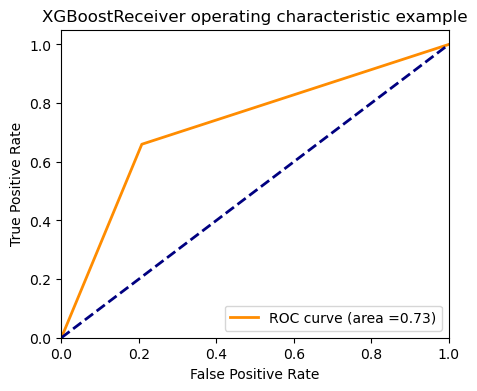

XGBoost_Ture_precision_score: 0.0856
XGBoost_Ture_recall_score : 0.6596
XGBoost_Ture_F1_score: 0.1516
XGBoost_False_precision_score: 0.9875
XGBoost_False_recall_score : 0.7925
XGBoost_False_F1_score: 0.8793
XGBoostaccuracy_score 0.7887


/var/folders/qy/w7ktgxnx5svft6xymt5d8k1w0000gq/T/ipykernel_66395/232486107.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)


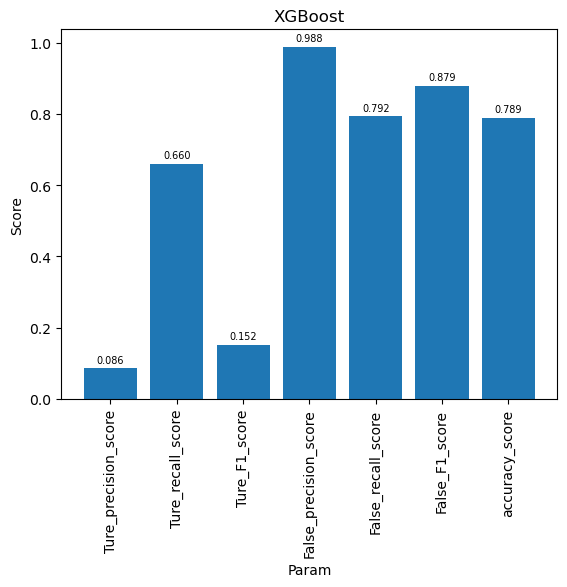

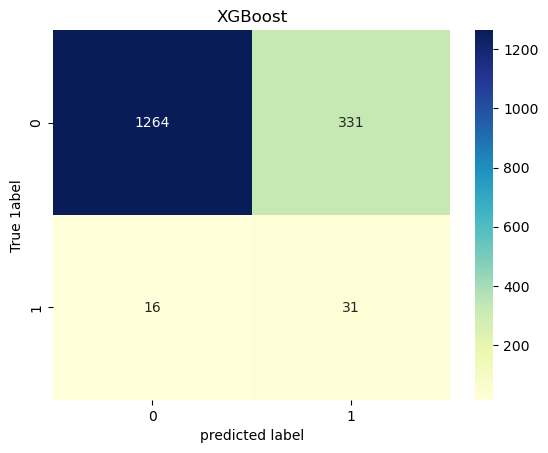

In [22]:
print ('AUC: %.4f' %metrics.roc_auc_score (Ytest, ypred))
print ('ACC: %.4f' %metrics.accuracy_score (Ytest, ypred))
print ('Recall: %.4f' %metrics.recall_score (Ytest, ypred))
print ('F1-score: %.4f' %f1_score(Ytest, ypred))
print ('Precision: %.4f' %metrics.precision_score(Ytest, ypred))

from sklearn.metrics import classification_report
print(classification_report(Ytest, ypred))
print (metrics.confusion_matrix(Ytest, ypred))

roc_auc_fig('XGBoost',Ytest,ypred)
evaluation ('XGBoost', Ytest,ypred)
matrix_fig('XGBoost' ,Ytest,ypred)